# In-memory caching tutorial

This notebook shows how to use in-memory caching, which allows to cache results between runs without writing to disk. This uses the `InMemoryResultStore` and `InMemoryMetadataStore` classes.

> ⛔ In-memory caching can consume a lot of memory if you're using storing large results. Selectively caching nodes is recommended.

If you're new to caching, you should take a look at the [caching tutorial](./tutorial.ipynb) first!

## Setup
Throughout this tutorial, we'll be using the Hamilton notebook extension to define dataflows directly in the notebook ([see tutorial](https://github.com/DAGWorks-Inc/hamilton/blob/main/examples/jupyter_notebook_magic/example.ipynb)).

Then, we get the logger for caching and clear previously cached results.

In [1]:
import logging
import shutil

# avoid loading all available plugins for fast startup time
from hamilton import registry
registry.disable_autoload()
registry.load_extension("pandas")

from hamilton import driver

# load the notebook extension
%reload_ext hamilton.plugins.jupyter_magic

logger = logging.getLogger("hamilton.caching")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

shutil.rmtree("./.hamilton_cache", ignore_errors=True)

## Define a dataflow
We define a simple dataflow that loads a dataframe of transactions, filters by date, converts currency to USD, and sums the amount per country.

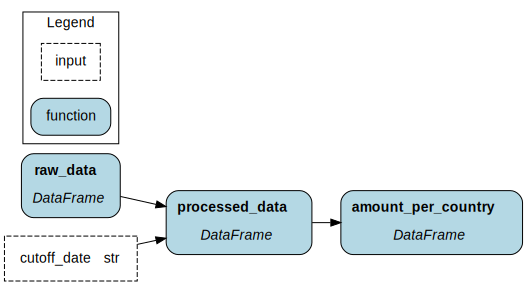

In [2]:
%%cell_to_module dataflow_module --display
import pandas as pd

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56],
    "country": ["USA", "USA", "USA", "Canada", "Canada"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD"],
}

def raw_data() -> pd.DataFrame:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    return pd.DataFrame(DATA)

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18  # <- LINE ADDED
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05  # <- LINE ADDED
    return df

def amount_per_country(processed_data: pd.DataFrame) -> pd.DataFrame:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum().to_frame()

## In-memory caching
To use in-memory caching, pass `InMemoryResultStore` and `InMemoryMetadataStore` to  `Builder().with_cache()`.

In [3]:
from hamilton.caching.stores.memory import InMemoryMetadataStore, InMemoryResultStore

dr = (
    driver.Builder()
    .with_modules(dataflow_module)
    .with_cache(
        result_store=InMemoryResultStore(),
        metadata_store=InMemoryMetadataStore(),
    )
    .build()
)

### Execution 1
For execution 1, we see that all nodes are executed.

raw_data::adapter::execute_node
processed_data::adapter::execute_node



        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD       478.2300
1  Los Angeles  2024-09-12  251.67     USA      USD       251.6700
2      Chicago  2024-09-11  989.34     USA      USD       989.3400
3     Montréal  2024-09-11  742.14  Canada      CAD       526.9194
4    Vancouver  2024-09-09  584.56  Canada      CAD       415.0376


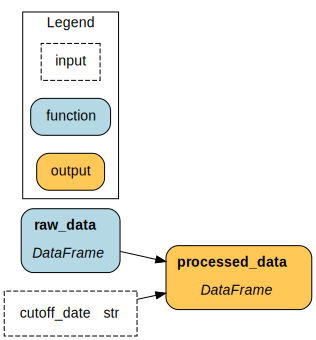

In [4]:
results = dr.execute(["processed_data"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["processed_data"].head())
dr.cache.view_run()

### Execution 2
For execution 2, we see that all nodes are retrieved from cache.

raw_data::result_store::get_result::hit
processed_data::result_store::get_result::hit



        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD       478.2300
1  Los Angeles  2024-09-12  251.67     USA      USD       251.6700
2      Chicago  2024-09-11  989.34     USA      USD       989.3400
3     Montréal  2024-09-11  742.14  Canada      CAD       526.9194
4    Vancouver  2024-09-09  584.56  Canada      CAD       415.0376


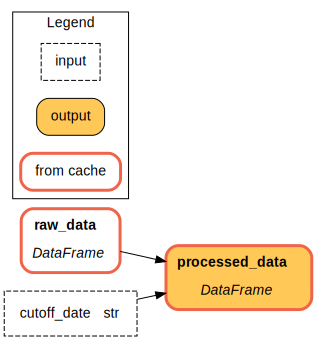

In [5]:
results = dr.execute(["processed_data"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["processed_data"].head())
dr.cache.view_run()

## Persisting in-memory data

Now, we import `SQLiteMetadataStore` and `FileResultStore` to persist the data to disk. We access the in-memory stores via `dr.cache.result_store` and `dr.cache.metadata_store` and call the `.persist_to()` method on each.

After executing the cell, you should see a new directory `./.persisted_cache` with results and metadata.

In [6]:
from hamilton.caching.stores.sqlite import SQLiteMetadataStore
from hamilton.caching.stores.file import FileResultStore

path = "./.persisted_cache"
on_disk_results = FileResultStore(path=path)
on_disk_metadata = SQLiteMetadataStore(path=path)

dr.cache.result_store.persist_to(on_disk_results)
dr.cache.metadata_store.persist_to(on_disk_metadata)

## Loading persisted data

Now, we create a new `Driver`. Instead of starting with empty in-memory stores, we will load the previously persisted results by calling `.load_from()` on the `InMemoryResultStore` and `InMemoryMetadataStore` classes.

For `InMemoryResultStore.load_from()`, we must provide a `MetadataStore` or a list of `data_version` to load results for.

In [7]:
dr = (
    driver.Builder()
    .with_modules(dataflow_module)
    .with_cache(
        result_store=InMemoryResultStore.load_from(
            on_disk_results,
            metadata_store=on_disk_metadata,
        ),
        metadata_store=InMemoryMetadataStore.load_from(on_disk_metadata),
    )
    .build()
)

We print the size of the metadata store to show it contains 2 entries (one for `raw_data` and another for `processed_data`). Also, we see that results load from `FileResultStore`are successfully retrieved from the in-memory stores.

raw_data::result_store::get_result::hit
processed_data::result_store::get_result::hit


2

        cities        date  amount country currency  amound_in_usd
0     New York  2024-09-13  478.23     USA      USD       478.2300
1  Los Angeles  2024-09-12  251.67     USA      USD       251.6700
2      Chicago  2024-09-11  989.34     USA      USD       989.3400
3     Montréal  2024-09-11  742.14  Canada      CAD       526.9194
4    Vancouver  2024-09-09  584.56  Canada      CAD       415.0376


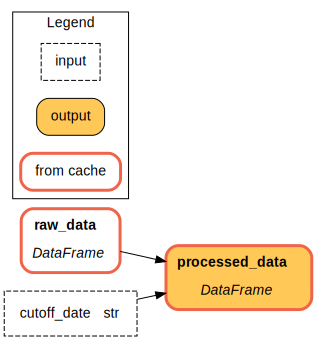

In [8]:
print(dr.cache.metadata_store.size)

results = dr.execute(["processed_data"], inputs={"cutoff_date": "2024-09-01"})
print()
print(results["processed_data"].head())
dr.cache.view_run()

## Use cases

In-memory caching can be useful when you're doing a lot of experimentation in a notebook or an interactive session and don't want to persist results for future use. 

It can also speed up execution in some cases because you're no longer doing read/write to disk for each node execution.